# Single instance

In [1]:
# using Yao, QAOA, Random, Combinatorics, Arpack, Distributions, LinearAlgebra, , FFTW
using QAOA, Distributions, Interpolations, LinearAlgebra
using HDF5, Printf
using PythonPlot
PythonPlot.matplotlib.style.use("./paper.mplstyle")
PythonPlot.rc("axes", prop_cycle=PythonPlot.matplotlib.cycler(color=["#2D5FAA", "#B7293F", "#438E6A", "#F7BD2E", "#F16C37"]))

# PATH = "../";
PATH = "/home/ubuntu/Archives/"
PLOT_PATH = "/home/ubuntu/Archives/plots/SK_model/paper/";

    CondaPkg Found dependencies: /home/ubuntu/.julia/environments/v1.8/CondaPkg.toml
    CondaPkg Found dependencies: /home/ubuntu/.julia/packages/PythonCall/wXfah/CondaPkg.toml
    CondaPkg Found dependencies: /home/ubuntu/.julia/packages/PythonPlot/KcWMF/CondaPkg.toml
    CondaPkg Dependencies already up to date


In [3]:
using Revise, SpinFluctuations

In [4]:
Base.show(io::IO, f::Float64) = @printf(io, "%1.4f", f)

In [5]:
N = 9
# N = 13
# N = 19

patterns_dict = Dict(
    9 => r"random_SK_instance_N_9_seed_(\d+)\.h5",
    11 => r"random_SK_instance_N_11_seed_(\d+)\.h5",
    13 => r"random_SK_instance_N_13_seed_(\d+)\.h5",
    15 => r"random_SK_instance_N_15_seed_(\d+)\.h5",
    17 => r"random_SK_instance_N_17_seed_(\d+)\.h5",
    19 => r"random_SK_instance_N_19_seed_(\d+)\.h5"
);

# folder_name = PATH * @sprintf("data/")
subdir = "small_gaps"
# subdir = "large_gaps"
folder_name = PATH * @sprintf("data/SK_model/N_%i/%s/", N, subdir)
instance_names = readdir(folder_name);

In [329]:
# N = 9
# small 
# seed = 12778 # => 0.6085
# seed = 73014 # => 0.7356
# seed = 65343 # => 0.7854
# seed = 57220 # => 0.8052
# seed = 47297 # => 0.8217
# seed = 78653 # => 0.8303
# seed = 46944 # => 0.8403
# seed = 70592 # => 0.8467
# seed = 62565 # => 0.8595
# seed = 87929 # => 0.8867
seed = 39879 # => 1.0371, 5th excited state - hardest instance as example!
seed = 63685 # => 1.2428, 4th excited state

# seed = 38906
# seed = 23320

# seed = 11414 # not actually hard
# seed = 11048 # interesting

# looking at max. peaks
seed = 23583 # very high fraction peak, great illustration!
# seed = 1291
# seed = 11456
# seed = 22824

# large
# seed = 100210

23583

In [330]:
# N = 13
# seed = 36733

# N = 19
# small
# seed = 538 # => 0.4583
# seed = 628 # => 0.4771
# seed = 147 # => 0.5004
# seed = 63 # => 0.5323
# seed = 914 # => 0.5950
# seed = 863 # => 0.7336
# seed = 699 # => 0.7725
# seed = 1238 # => 0.7753
# seed = 18 # => 0.8269
# seed = 319 # => 0.8990 - GREAT ILLUSTRATION!
# seed = 674 # => 0.9061
# seed = 554 # => 1.0416

In [331]:
h5open(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed))

🗂️ HDF5.File: (read-only) /home/ubuntu/Archives/data/SK_model/N_9/small_gaps/random_SK_instance_N_9_seed_23583.h5
├─ 🔢 J
├─ 🔢 exact_ARPACK_LM_eigvals
└─ 🔢 exact_ARPACK_LM_lowest_eigvecs

In [332]:
# h5open(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed))

In [333]:
J_mat = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "J")
mf_problem = Problem(0, J_mat);

λ = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_eigvals");

In [334]:
# npts = 2048
npts = 8192
coarse_times = range(0, 1, npts + 1);

## Exact gap

In [345]:
# T_final = 32768
T_final = 32000
tol = 1e-8;

In [346]:
exact_times = range(0, 1, 33);

In [347]:
gap = λ[2, :] .- λ[1, :];
mingap = minimum(gap) 
mingap |> println
gap_idx = findfirst(x -> x == mingap, gap) 
gaploc = exact_times[gap_idx] 
gaploc |> println

0.0017
0.7812


In [348]:
small_idxs = findall(x -> x < 0.05, gap ./ (2pi)) 
gap_interval = exact_times[small_idxs];

In [349]:
bogo_spec = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("bogoliubov_spectrum_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(tol), 32));

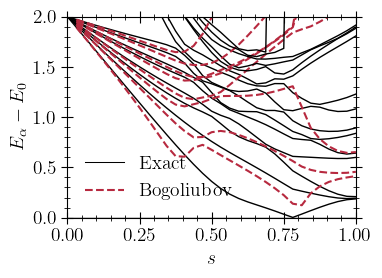

In [350]:
figure(figsize=(4, 3))
subplot(111)
for i in 1:size(bogo_spec)[1]
    plot(exact_times[2:end], bogo_spec[i, :], "--C1", lw=1.5, alpha=1, ms=2)
    plot(exact_times, (λ[i, :] .- λ[1, :]), "-k", lw=1, alpha=1, ms=2)    
end
# axvline(gap_interval[1], c="C0")
# axvline(gap_interval[end], c="C0")
plot([], [], "-k", lw=0.75, label="Exact")
plot([], [], "--C1", lw=1.5, label="Bogoliubov")
xlim(0., 1.)
ylim(-0., 2)
xlabel("\$s\$")
ylabel("\$E_\\alpha - E_0\$")
legend(frameon=false)
tight_layout()
display(gcf())
PythonPlot.close();

### Eigenstates

In [351]:
all_eigvecs = h5read(folder_name * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), "exact_ARPACK_LM_lowest_eigvecs");

In [352]:
H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem.local_fields, mf_problem.couplings)
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem.local_fields, mf_problem.couplings);

In [353]:
gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)]

overlap_01_x = [first_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_01_z = [first_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)]

overlap_02_x = [second_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_02_z = [second_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

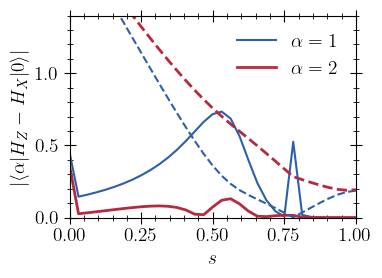

In [354]:
figure(figsize=(4, 3))
ax = subplot(111)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x) , label="\$\\alpha = 1\$")
plot(exact_times, abs.(overlap_02_z .- overlap_02_x) , label="\$\\alpha = 2\$", lw=2)
plot(exact_times, ((λ[2, :] .- λ[1, :])), "--C0")
plot(exact_times, ((λ[3, :] .- λ[1, :])), "--C1", lw=2)
xlim(0., 1.)
ylim(0, 1.4)
xlabel("\$s\$")
ylabel("\${|\\langle \\alpha|H_Z-H_X|0\\rangle|}\$")

legend(frameon=false)

tight_layout()
display(gcf())
PythonPlot.close();

## Mean-field trajectories

In [448]:
T_final = 32768.
tol = 1e-6;

In [449]:
sol_t = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/times", T_final, log10(tol)))
sol_u = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("mean_field_T_final_%.0f_tol_1e%.0f/trajectories", T_final, log10(tol)));

In [450]:
size(sol_u)

(100217, 3, 8)

### Bloch coordinates

In [451]:
nx_vals = n_vals("x", sol_u)
ny_vals = n_vals("y", sol_u)
nz_vals = n_vals("z", sol_u);

In [452]:
nx_coarse = n_coarse(nx_vals, sol_t, coarse_times)
ny_coarse = n_coarse(ny_vals, sol_t, coarse_times)
nz_coarse = n_coarse(nz_vals, sol_t, coarse_times);

In [455]:
areas = Dict()
# dts = [(x[2] - x[1]) / T_final for x in zip(sol_t[1:end-1], sol_t[2:end])]
dts = [(x[2] - x[1]) / T_final for x in zip(coarse_times[1:end-1], coarse_times[2:end])]
for spin_idx in 1:N-1
    # areas[spin_idx] = sum(dts .* nz_vals[spin_idx, 2:end]) |> abs
    areas[spin_idx] = sum(dts .* magnetizations[spin_idx, 2:end]) |> abs
end

top_idxs = [k for (k, v) in sort(areas |> collect, by=x->x[2])]
top_idx = top_idxs[1]

3

In [462]:
regular_trajectories = filter!(x -> x != top_idx, collect(1:N-1));

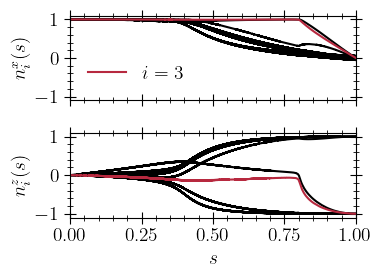

In [463]:
figure(figsize=(4, 3))

ax = subplot(211)
for spin_nr in regular_trajectories
    plot(sol_t ./ T_final, nx_vals[spin_nr, :], "-", c="k")    
end
plot(sol_t ./ T_final, nx_vals[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ax.set_xticklabels([])
ylim(-1.1, 1.1)
ylabel("\$n_i^x(s)\$")
legend(frameon=false, ncol=2)

ax = subplot(212)
for spin_nr in regular_trajectories
    plot(sol_t ./ T_final, nz_vals[spin_nr, :], "-", c="k")    
end
plot(sol_t ./ T_final, nz_vals[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ylim(-1.1, 1.1)
xlabel("\$s\$")
ylabel("\$n_i^z(s)\$")
# legend(frameon=false, ncol=2)

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

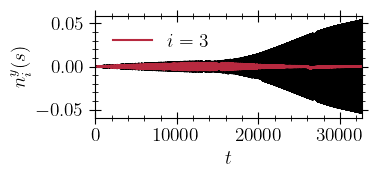

In [464]:
figure(figsize=(4, 2))


ax = subplot(111)
for spin_nr in regular_trajectories
    plot(sol_t, ny_vals[spin_nr, :], "-", c="k")    
end
plot(sol_t, ny_vals[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0.0, T_final)
# ylim(-1e-3, 1e-3)
xlabel("\$t\$")
ylabel("\$n_i^y(s)\$")
legend(frameon=false)


tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

### Magnetization

In [465]:
S_vals = [transpose(reduce(hcat, [nx_coarse[:, k], ny_coarse[:, k], nz_coarse[:, k]])) |> Matrix for k in 1:npts+1]
magnetizations = reduce(hcat, map(S -> magnetization(S, mf_problem.local_fields, mf_problem.couplings), S_vals));

In [466]:
function regularize(x; ε=1e-1)
    pv = x / (x^2 + ε^2)
    abs(x) < ε^2 ? pv : 1/x
end

regularize (generic function with 1 method)

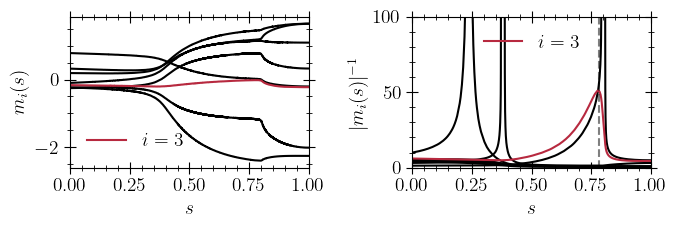

In [467]:
figure(figsize=(7, 2.5))


ax = subplot(121)
for spin_nr in regular_trajectories
    plot(coarse_times, magnetizations[spin_nr, :], "-", c="k")
end
plot(coarse_times, magnetizations[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0.0, 1)
# ylim(-1000,  1000)
xlabel("\$s\$")
ylabel("\$m_i(s)\$")
legend(frameon=false)

ax = subplot(122)
plot_func = x -> regularize.(x, ε=1e-3)
# plot_func = x -> x ./ (x.^2 .+ 1e-4)

for spin_nr in regular_trajectories
    # plot(coarse_times, plot_func(abs.(magnetizations[spin_nr, :])), "-", c="k")    
    plot(coarse_times, smoothen(plot_func(abs.(magnetizations[spin_nr, :])), coarse_times, navg=128), "-", c="k")
end
# plot(coarse_times, plot_func(abs.(smoothen(magnetizations[top_idx, :], coarse_times))), "-", c="C5", label=@sprintf("\$i=%i\$", top_idx))
plot(coarse_times, smoothen(plot_func(abs.(magnetizations[top_idx, :])), coarse_times, navg=128), "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
axvline(gaploc, ls="--", c="k", alpha=0.5)
xlim(0.0, 1)
ylim(0, 100)
xlabel("\$s\$")
ylabel("\$|m_i(s)|^{-1}\$")
legend(frameon=false)


tight_layout()
display(gcf())
PythonPlot.close();

### Complex coordinates

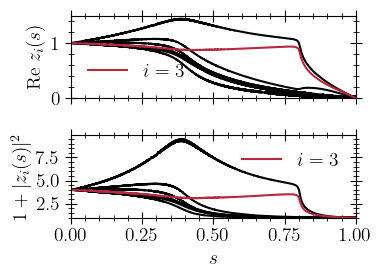

In [468]:
figure(figsize=(4, 3))

ax = subplot(211)
for spin_nr in regular_trajectories
    plot(coarse_times, complex_coordinate(spin_nr, nx_coarse, ny_coarse, nz_coarse) |> real, "-", c="k")    
end
plot(coarse_times, complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse) |> real, "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ylim(-0, 1.5) 
ax.set_xticklabels([])
# xlabel("\$s\$")
ylabel("\$\\mathrm{Re}\\; z_i(s)\$")
legend(frameon=false, ncol=2)

ax = subplot(212)
for spin_nr in regular_trajectories
    plot(coarse_times, (1 .+ abs.(complex_coordinate(spin_nr, nx_coarse, ny_coarse, nz_coarse)).^2).^2, "-", c="k")
end
plot(coarse_times, (1 .+ abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse)).^2).^2, "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))

xlim(0, 1)
ylim(1, ) 
xlabel("\$s\$")
# ylabel("\$1 + [\\mathrm{Re}\\; z_i(s)]^2\$")
ylabel("\$1 +  |z_i(s)|^2\$")
legend(frameon=false, ncol=2)

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

### Energies

In [469]:
# sigma_star = sign.(sol.u[end][3, :])
sigma_star = sign.(sol_u[end, 3, :])
h = mf_problem.local_fields
J = mf_problem.couplings
E = sum([-h[l] * sigma_star[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star[i] * sigma_star[j] for i in 1:N-1 for j in (i+1):N-1])

-4.7351

In [470]:
[λ[k, :][end] for k in 1:6] |> println

[-4.9214, -4.7351, -4.7284, -4.7130, -4.3222, -4.2792]


In [471]:
for spin_idx in 1:N-1
    # sigma_star_flip = sign.(sol.u[end][3, :])
    sigma_star_flip = sign.(sol_u[end, 3, :])
    sigma_star_flip[spin_idx] = (-1) * sigma_star_flip[spin_idx]
    E_flip = sum([-h[l] * sigma_star_flip[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star_flip[i] * sigma_star_flip[j] for i in 1:N-1 for j in (i+1):N-1])
    println(spin_idx, ": ", E_flip)
end

1: -1.4279
2: -4.3222
3: -4.2792
4: -0.2015
5: -2.5452
6: -1.4149
7: -0.6892
8: -4.0825


In [472]:
println(top_idxs)

[3, 8, 2, 5, 1, 6, 7, 4]


## Statistical Green function

In [473]:
tol = 1e-8
T_final = 32000.
# T_final = 32768.
T_final = 65536.;

In [474]:
# nx_coarse = reduce(hcat, [map(linear_interpolation(sol_t, nx_vals[spin_nr, :], extrapolation_bc=Line()), T_final .* coarse_times) for spin_nr in 1:N-1]) |> transpose
# nz_coarse = reduce(hcat, [map(linear_interpolation(sol_t, nz_vals[spin_nr, :], extrapolation_bc=Line()), T_final .* coarse_times) for spin_nr in 1:N-1]) |> transpose;

In [475]:
all_flucs = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("fluctuations_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(1e-8), npts));

In [476]:
regular_trajectories = filter!(x -> x != top_idxs[1], collect(1:N-1));
# regular_trajectories = filter!(x -> x != top_idxs[2], regular_trajectories);

scale_factors = [1 .+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)).^2 for i in 1:N-1]
# mean_scaled_flucs = mean([scale_factors[i].^2 .* smoothen(all_flucs[i, :], coarse_times) for i in regular_trajectories], dims=1)[1];
mean_scaled_flucs = mean([smoothen(all_flucs[i, :], coarse_times) for i in regular_trajectories], dims=1)[1];

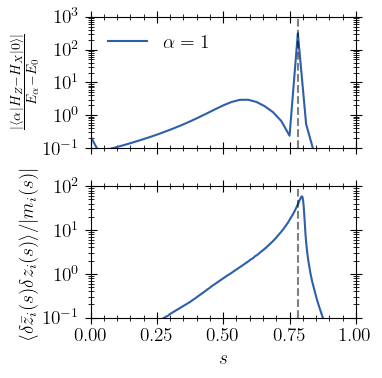

In [480]:
figure(figsize=(4, 4))
ax = subplot(211)
semilogy(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :])), label="\$\\alpha = 1\$")
# plot(exact_times, abs.(overlap_02_z .- overlap_02_x) ./ ((λ[3, :] .- λ[1, :])), label="\$\\alpha = 2\$", lw=2)
# semilogy(exact_times, (abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :]))) .+ (abs.(overlap_02_z .- overlap_02_x) ./ ((λ[3, :] .- λ[1, :]))), "-k", lw=2)
xlim(0., 1.)
ylim(1e-1, 1e3)
ax.set_xticklabels([])
ylabel("\$\\frac{|\\langle \\alpha|H_Z-H_X|0\\rangle|}{E_\\alpha - E_0}\$")
axvline(gaploc, ls="--", c="k", alpha=0.5)

legend(frameon=false)

reg_func = x -> regularize.(x, ε=5.0e-3)
# reg_func = x -> regularize.(x, ε=5.0e-2)
# inv_mag = smoothen(reg_func(abs.(magnetizations[top_idx, :])), coarse_times, navg=128)
inv_mag = reg_func(abs.(magnetizations[top_idx, :]))

subplot(212)
for i in 1:1#(N-1)÷2
    scale_factor = 1 .+ abs.(complex_coordinate(top_idxs[i], nx_coarse, ny_coarse, nz_coarse)).^2
    # plot(coarse_times, scale_factor.^2 .* smoothen(all_flucs[top_idxs[i], :], coarse_times) .- mean_scaled_flucs)
    # plot(coarse_times, (smoothen(all_flucs[top_idxs[i], :], coarse_times) .- mean_scaled_flucs) .* inv_mag)
    
    semilogy(coarse_times, smoothen(scale_factor.^2 .* all_flucs[top_idxs[i], :] .* inv_mag, coarse_times))
    # plot(coarse_times, smoothen(scale_factor.^2 .* all_flucs[top_idxs[i], :] .* inv_mag, coarse_times))
end

axvline(gaploc, ls="--", c="k", alpha=0.5)
xlim(0, 1)
ylim(1e-1, 1e2)
xlabel("\$s\$")
ylabel("\$ \\langle\\delta \\bar z_i(s) \\delta z_i(s) \\rangle / |m_i(s)|\$")

tight_layout()
display(gcf())
PythonPlot.close();

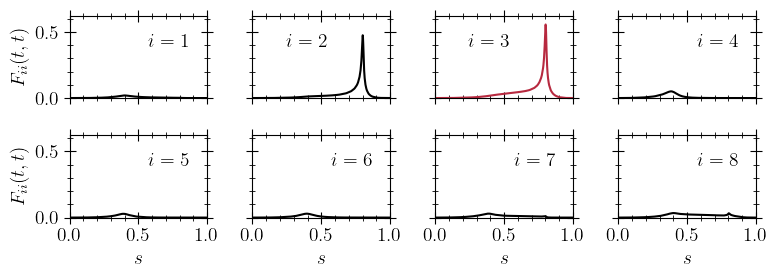

In [478]:
figure(figsize=(8, 3))
normalization = maximum(smoothen(all_flucs[top_idxs[1], :], coarse_times))
normalization = 1.
ylims = (0, maximum(all_flucs ./ normalization))
# ylims = (0, ceil(Int, maximum(all_flucs ./ normalization)))
for i in 1:(N-1)÷2
    ax = subplot(2, (N-1)÷2, i)
    c = "k"
    if i in top_idxs[1:1]
        c = "C1"
    end
    plot(coarse_times, smoothen(all_flucs[i, :], coarse_times) ./ normalization, label=@sprintf("\$i=%s\$", string(i)), c=c)
    xlim(0., 1.)
    ax.set_xticklabels([])
    ylim(ylims...)
    if i > 1
        ax.set_yticklabels([])
    end
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, (N-1)÷2, 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

for i in (N-1)÷2+1:N-1
    ax = subplot(2, (N-1)÷2, i)
    c = "k"
    if i in top_idxs[1:1]
        c = "C1"
    end
    plot(coarse_times, smoothen(all_flucs[i, :], coarse_times) ./ normalization, label=@sprintf("\$i=%s\$", string(i)), c=c)
    xlim(0., 1.)
    ylim(ylims...)
    if i > (N-1)÷2+1
        ax.set_yticklabels([])
    end    
    xlabel("\$s\$")    
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, (N-1)÷2, (N-1)÷2 + 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("fluctuations_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

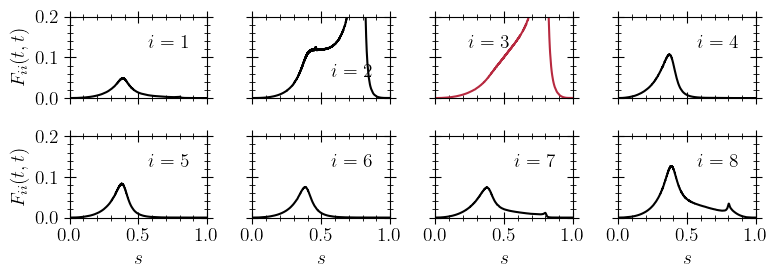

In [479]:
figure(figsize=(8, 3))
# normalization = maximum((1 .+ (nx_coarse[top_idxs[1], :] ./ (1 .+ sign(nz_coarse[top_idxs[1], end]) .* nz_coarse[top_idxs[1], :])).^2) .* (smoothen(all_flucs[top_idxs[1], :] .+ 0.0im, coarse_times) .|> sqrt |> real))
normalization = 1.
ylims = (0, 0.2)

for i in 1:(N-1)÷2
    ax = subplot(2, (N-1)÷2, i)
    c = "k"
    if i in top_idxs[1:1]
        c = "C1"
    end
    scale_factor = 1 .+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)).^2
    plot(coarse_times, scale_factor.^2 .* smoothen(all_flucs[i, :], coarse_times), label=@sprintf("\$i=%s\$", string(i)), c=c)
    # plot(coarse_times, (scale_factor / normalization) .* (smoothen(all_flucs[i, :] .+ 0.0im, coarse_times) .|> sqrt |> real), label=@sprintf("\$i=%s\$", string(i)), c=c)
    # plot(coarse_times, smoothen(scale_factor .* real(sqrt.(all_flucs[i, :] .+ 0.0im)), coarse_times), label=@sprintf("\$i=%s\$", string(i)), c=c)
    xlim(0., 1.)
    ax.set_xticklabels([])
    ylim(ylims...)
    if i > 1
        ax.set_yticklabels([])
    end
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, (N-1)÷2, 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

for i in (N-1)÷2+1:N-1
    ax = subplot(2, (N-1)÷2, i)
    c = "k"
    if i in top_idxs[1:1]
        c = "C1"
    end
    scale_factor = 1 .+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)).^2
    plot(coarse_times, scale_factor.^2 .* smoothen(all_flucs[i, :], coarse_times), label=@sprintf("\$i=%s\$", string(i)), c=c)
    # plot(coarse_times, (scale_factor / normalization) .*  (smoothen(all_flucs[i, :] .+ 0.0im, coarse_times) .|> sqrt |> real), label=@sprintf("\$i=%s\$", string(i)), c=c)
    # plot(coarse_times, smoothen(scale_factor .* real(sqrt.(all_flucs[i, :] .+ 0.0im)), coarse_times), label=@sprintf("\$i=%s\$", string(i)), c=c)
    xlim(0., 1.)
    ylim(ylims...)
    if i > (N-1)÷2+1
        ax.set_yticklabels([])
    end    
    xlabel("\$s\$")    
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, (N-1)÷2, (N-1)÷2 + 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("fluctuations_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

In [296]:
tol = 1e-8
T_final = 32768.
npts = 4096
coarse_times_fine = range(0, 1, npts + 1);
all_flucs_fine = h5read(folder_name * @sprintf("results_random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("fluctuations_T_final_%.0f_tol_1e%.0f_npts_%i", T_final, log10(1e-8), npts));

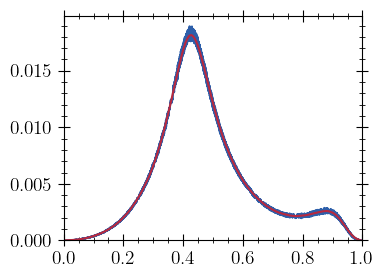

In [50]:
figure(figsize=(4, 3))
# plot(coarse_times, mean(new_all_flucs, dims=1)[1, :])
# plot(coarse_times, mean(all_flucs, dims=1)[1, :])
plot(coarse_times_fine, mean(all_flucs_fine, dims=1)[1, :])
plot(coarse_times, smoothen(mean(all_flucs, dims=1)[1, :], coarse_times), "-")
tight_layout()
xlim(0, 1)
ylim(0, )
display(gcf())
tight_layout()
PythonPlot.close();

## Spectrum

In [ ]:
T_final = 32768.
tol = 1e-6
τ_final = 2048.

npts_diag = 16
T_diags = T_final .* range(0.5, 1.0, npts_diag+1)

ωs = []
spec_sum = []
for k in 1:17
    push!(ωs, h5read(folder_name * "results_" * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("spectra_T_final_%i_tau_final_%i/T_%0.5f/omegas", T_final, τ_final, T_diags[k] / T_final)))
    push!(spec_sum, h5read(folder_name * "results_" * @sprintf("random_SK_instance_N_%i_seed_%i.h5", N, seed), @sprintf("spectra_T_final_%i_tau_final_%i/T_%0.5f/data", T_final, τ_final, T_diags[k] / T_final)))
end   

In [ ]:
t_idx = 8
println(T_diags[t_idx] ./ T_final)

In [ ]:
figure(figsize=(4, 3))
ax = subplot(111)
for k in [t_idx]
    plot(2pi .* ωs[k], spec_sum[k])
end
axvline.(bogo_spec[N:end, 16 + t_idx], c="C1", alpha=0.8, ls="--", lw=1.5)
xlim(0.25, 2.5)
ylim(-0., 1)
xlabel("\$\\omega\$")
ylabel("\$\\mathrm{Tr}\\;{\\rho}(T, \\omega)\$", fontsize=12)
tight_layout()
display(gcf())
PythonPlot.close();

## Testing

In [ ]:
figure(figsize=(5, 2))


subplot(121)
plot(coarse_times, sum([(all_flucs[top_idxs[k], :] .- mean(all_flucs, dims=1)[1, :])  for k in 1:1]))
plot(coarse_times, sum([(all_flucs[top_idxs[k], :] .- mean(all_flucs, dims=1)[1, :])  for k in 1:2]))
axvline(gaploc, c="r")
# axvline(gap_interval[1], c="k")
# axvline(gap_interval[end], c="k")
xlim(0, 1)
ylim(0, )

subplot(122)
plot(coarse_times, all_flucs[top_idxs[1], :] .- mean(all_flucs, dims=1)[1, :])
plot(coarse_times, all_flucs[top_idxs[2], :] .- mean(all_flucs, dims=1)[1, :])
plot(coarse_times, all_flucs[top_idxs[4], :] .- mean(all_flucs, dims=1)[1, :])
axvline(gaploc, c="r")
# axvline(gap_interval[1], c="k")
# axvline(gap_interval[end], c="k")
xlim(0, 1)
# ylim(0, )
tight_layout()
display(gcf())